## Perturbation of sequences
### Dataset: HEV ORF2 Sequences of Human only
### Number of sequences = 694
### Max Seq Length = 794
### Model: Transformer

In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbat

In [3]:
from models.nlp.transformer import transformer, transformer_model
from models.nlp import lstm, cnn1d
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from utils import utils, nn_utils, visualization_utils
from models.nlp.embedding.padding import Padding
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [4]:
input_file_path = "/home/grads/blessyantony/dev/git/zoonosis/input/data/hev/aligned/hev_orf2_alignment_ba.fasta_processed.csv"
output_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/hev/20231017/perturbed_dataset_prediction/orf2-aligned/transformer-l_6-h_8-lr1e-4/processed"
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/hev/20231012/host_multi_e50/orf2/transformer-l_6-h_8-lr1e-4-orf2_itr0.pth"


hev_df = pd.read_csv(input_file_path)

label_groupings = {
                    "Human": [ "Human" ],
                    "Boar": [ "Boar" ],
                    "Others": [ "*" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26, "-": 0}

idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}
id_col = "id"
test_sequence_settings =  {
    "sequence_col": "sequence",
    "batch_size": 1,
    "max_sequence_length": 794,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}


label_settings = {
    "label_col": "host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 794,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 3,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

def post_plot_config():
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 8

In [5]:
hev_df

,id,region,host,genotype,host-genotype,sequence
0,QJQ50414.1,ORF2,Avian,unknown,Avian-unknown,---------------------------MSLRGLLLM----------...
1,UNQ84076.1,ORF2,Avian,unknown,Avian-unknown,---------------------------MSVRGLLLM----------...
2,UBR27794.1,ORF2,Avian,unknown,Avian-unknown,---------------------------MSLRGLLLM----------...
3,UBR27790.1,ORF2,Avian,unknown,Avian-unknown,---------------------------MSLRGLLLM----------...
4,QAT90247.1,ORF2,Avian,unknown,Avian-unknown,---------------------------MSLRGLLLM----------...
...,...,...,...,...,...,...
930,QED22687.1,ORF2,Rodent,NaN,Rodent-nan,------------MCSQ-------------------CLLIFG-----...
931,AVP32825.1,ORF2,Rodent,unknown,Rodent-unknown,MWGRKNNIHCRALCTNV--------LAMHTYFWLLCYLML------...
932,AVP32822.1,ORF2,Rodent,unknown,Rodent-unknown,MWGRKNNIHCCALCTNV--------LAMHTYFWLLCYLLL------...
933,AQT40965.1,ORF2,Bat,unknown,Bat-unknown,----MNNT-------------PFPILVMDPRAALLLFLICSGAHGS...


In [6]:
hev_human_df = hev_df[hev_df["host"] == "Human"]
hev_human_df

,id,region,host,genotype,host-genotype,sequence
10,BAD74177.1,ORF2,Human,HEV3,Human-HEV3,---------------------------MRPRAVLLLFFVL------...
11,BAD74180.1,ORF2,Human,HEV3,Human-HEV3,---------------------------MRPRAVLLLFFVL------...
13,BAD74183.1,ORF2,Human,HEV3,Human-HEV3,---------------------------MRPRAVLLLFFVL------...
14,BAD74174.1,ORF2,Human,HEV3,Human-HEV3,---------------------------MRPRAVLLLFFVL------...
15,BBF24564.1,ORF2,Human,HEV3,Human-HEV3,---------------------------MRPRAVLLLFFVL------...
...,...,...,...,...,...,...
903,QAU19547.1,ORF2,Human,unknown,Human-unknown,---------------------------MRVTF-VLVLLLL------...
906,QEV82318.1,ORF2,Human,unknown,Human-unknown,---------------------------MSVVV-VLVLLLF------...
908,QEV82321.1,ORF2,Human,unknown,Human-unknown,---------------------------MSVVV-VLVLLLF------...
909,QEV82327.1,ORF2,Human,unknown,Human-unknown,---------------------------MSVVV-VLVLLLF------...


In [7]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")

    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))


def get_dataset_loader_for_seq(genbank_id):
    id_df = hev_human_df[hev_human_df["id"] == genbank_id]
    index_label_map, dataset_loader =  get_token_dataset_loader(id_df, test_sequence_settings, label_settings)
    return id_df, index_label_map, dataset_loader

def get_aligned_seq(genbank_id):
    aligned_seq_row = hev_human_df[hev_human_df["id"] == genbank_id]
    aligned_seq = aligned_seq_row["seq"].values[0]
    aligned_token_count = aligned_seq_row["aligned_token_count"].values[0]
    return aligned_seq, aligned_token_count

### Load the model

In [8]:
tf_custom_model = transformer.get_transformer_model(model)
tf_custom_model.load_state_dict(torch.load(model_path))
tf_custom_model = tf_custom_model.to(nn_utils.get_device())
tf_custom_model.eval()
tf_custom_model.zero_grad()

Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=3, b

In [9]:
def validate(model, dataset_loader, index_label_map):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df.rename(columns=index_label_map, inplace=True)
            result_df["y_true"] = labels.cpu().numpy()
            result_df["y_true"] = result_df["y_true"].map(index_label_map)
            
            results.append(result_df)
    
    return inputs, pd.concat(results, ignore_index=True)

In [10]:
def get_aligned_seq_pos_mapping(seq):
    aligned_seq_pos_map = {}
    token_count = 0
    for i, token in enumerate(seq):
        if token == "-":
            aligned_seq_pos_map[i] = 0
        else:
            token_count += 1
            aligned_seq_pos_map[i] = token_count
    return aligned_seq_pos_map

In [12]:
output_files = os.listdir(output_dir)
print(f"Number of perturbed output files = {len(output_files)}")

diff_dfs = []
for output_file in output_files:
    regex_result = re.search(r"tf\_hev\_orf2\_alignment\_ba\.fasta\_processed\.csv\_([A-Z0-9\.]+)\.csv", output_file)
    genbank_id = regex_result.group(1)
    print(output_file)
    print(genbank_id)
    genbank_id_df, index_label_map, dataset_loader = get_dataset_loader_for_seq(genbank_id)
    
    inputs, output_df = validate(tf_custom_model, dataset_loader, index_label_map)
    perturbed_output_df = pd.read_csv(os.path.join(output_dir, output_file))
    orig_seq = genbank_id_df["sequence"].values[0]
    aligned_seq_pos_map = get_aligned_seq_pos_mapping(orig_seq)
    orig_seq_human_pred = output_df["Human"].values[0]
    perturbed_output_df = perturbed_output_df[["Human", "id", "orig_token", "perturb_pos", "new_token"]]
    perturbed_output_df["seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: aligned_seq_pos_map[x])
    perturbed_output_df["pred_diff"] = perturbed_output_df["Human"] - orig_seq_human_pred
    pivot_df = perturbed_output_df.pivot(columns="seq_pos", index="new_token", values="pred_diff")
    diff_dfs.append(pivot_df)
    break

Number of perturbed output files = 933
tf_hev_orf2_alignment_ba.fasta_processed.csv_QBF14545.1.csv
QBF14545.1
Grouping labels using config : {'Human': ['Human'], 'Boar': ['Boar'], 'Others': ['*']}
label_idx_map={'Boar': 0, 'Human': 1, 'Others': 2}
idx_label_map={0: 'Boar', 1: 'Human', 2: 'Others'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/hev-aligned/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [13]:
perturbed_output_df

,Human,id,orig_token,perturb_pos,new_token,seq_pos,pred_diff
0,0.437916,QBF14545.1,T,222,G,151,0.000259
1,0.437834,QBF14545.1,D,508,E,432,0.000177
2,0.438397,QBF14545.1,K,599,F,518,0.000740
3,0.437562,QBF14545.1,D,195,G,126,-0.000096
4,0.437749,QBF14545.1,A,264,P,190,0.000092
...,...,...,...,...,...,...,...
16496,0.438278,QBF14545.1,V,584,H,503,0.000621
16497,0.437942,QBF14545.1,A,639,F,555,0.000285
16498,0.437072,QBF14545.1,P,716,T,617,-0.000585
16499,0.437896,QBF14545.1,T,671,G,585,0.000239


In [14]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df["pred_diff"], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.117692,-0.102884,10,0.060602
1,-0.102884,-0.088076,9,0.054542
2,-0.088076,-0.073268,10,0.060602
3,-0.073268,-0.058461,17,0.103024
4,-0.058461,-0.043653,13,0.078783
5,-0.043653,-0.028845,11,0.066663
6,-0.028845,-0.014038,38,0.230289
7,-0.014038,0.000770,15891,96.303254
8,0.000770,0.015578,472,2.860433
9,0.015578,0.030385,7,0.042422


In [15]:
df = perturbed_output_df.pivot(columns="seq_pos", index="new_token", values="pred_diff")
df

seq_pos,1,2,3,4,5,6,7,8,9,10,...,651,652,653,654,655,656,657,658,659,660
new_token,,,,,,,,,,,,,,,,,,,,,
A,8.763931e-04,-0.001064,-0.000065,-0.001539,NaN,-0.000025,0.000478,0.000470,0.000469,0.000483,...,0.000340,0.000714,0.000351,0.000115,0.000297,0.000347,0.000535,0.000744,0.000022,0.000231
B,9.442531e-04,-0.000973,-0.000033,-0.001439,0.000028,-0.000064,0.000352,0.000290,0.000275,0.000293,...,0.000230,0.000592,0.000227,-0.000007,0.000175,0.000223,0.000398,0.000592,-0.000126,0.000094
C,-1.031469e-04,-0.002112,-0.001054,-0.002544,-0.000885,-0.000836,-0.000290,-0.000288,-0.000288,-0.000272,...,-0.000094,0.000265,-0.000103,-0.000339,-0.000167,-0.000131,0.000038,0.000225,-0.000494,-0.000277
D,6.217331e-04,-0.001323,-0.000278,-0.001777,-0.000208,-0.000238,0.000259,0.000244,0.000243,0.000259,...,0.000085,0.000449,0.000080,-0.000149,0.000043,0.000102,0.000293,0.000496,-0.000223,-0.000012
E,7.643131e-04,-0.001141,-0.000129,-0.001576,-0.000030,-0.000040,0.000470,0.000450,0.000436,0.000444,...,0.000286,0.000645,0.000292,0.000079,0.000280,0.000340,0.000528,0.000730,NaN,0.000211
F,1.963433e-03,0.000091,0.001017,-0.000373,0.001049,0.000916,0.001298,0.001222,0.001216,0.001249,...,0.000675,0.001034,0.000672,0.000440,0.000624,0.000685,0.000885,0.001100,0.000384,0.000606
G,4.518931e-04,-0.001500,-0.000454,-0.001974,-0.000395,-0.000406,0.000112,0.000116,0.000123,0.000131,...,0.000050,0.000419,0.000054,-0.000181,NaN,0.000048,0.000232,0.000434,-0.000282,-0.000073
H,5.289631e-04,-0.001441,-0.000366,-0.001797,-0.000075,0.000067,0.000671,0.000607,0.000435,0.000310,...,0.000135,0.000465,0.000065,-0.000172,0.000040,0.000143,0.000373,0.000580,-0.000163,0.000020
I,3.316131e-04,-0.001649,-0.000584,-0.002121,-0.000489,-0.000456,0.000098,0.000113,0.000115,0.000119,...,0.000067,0.000436,0.000071,-0.000164,0.000010,0.000054,0.000239,0.000443,-0.000266,-0.000051


<Figure size 640x480 with 0 Axes>

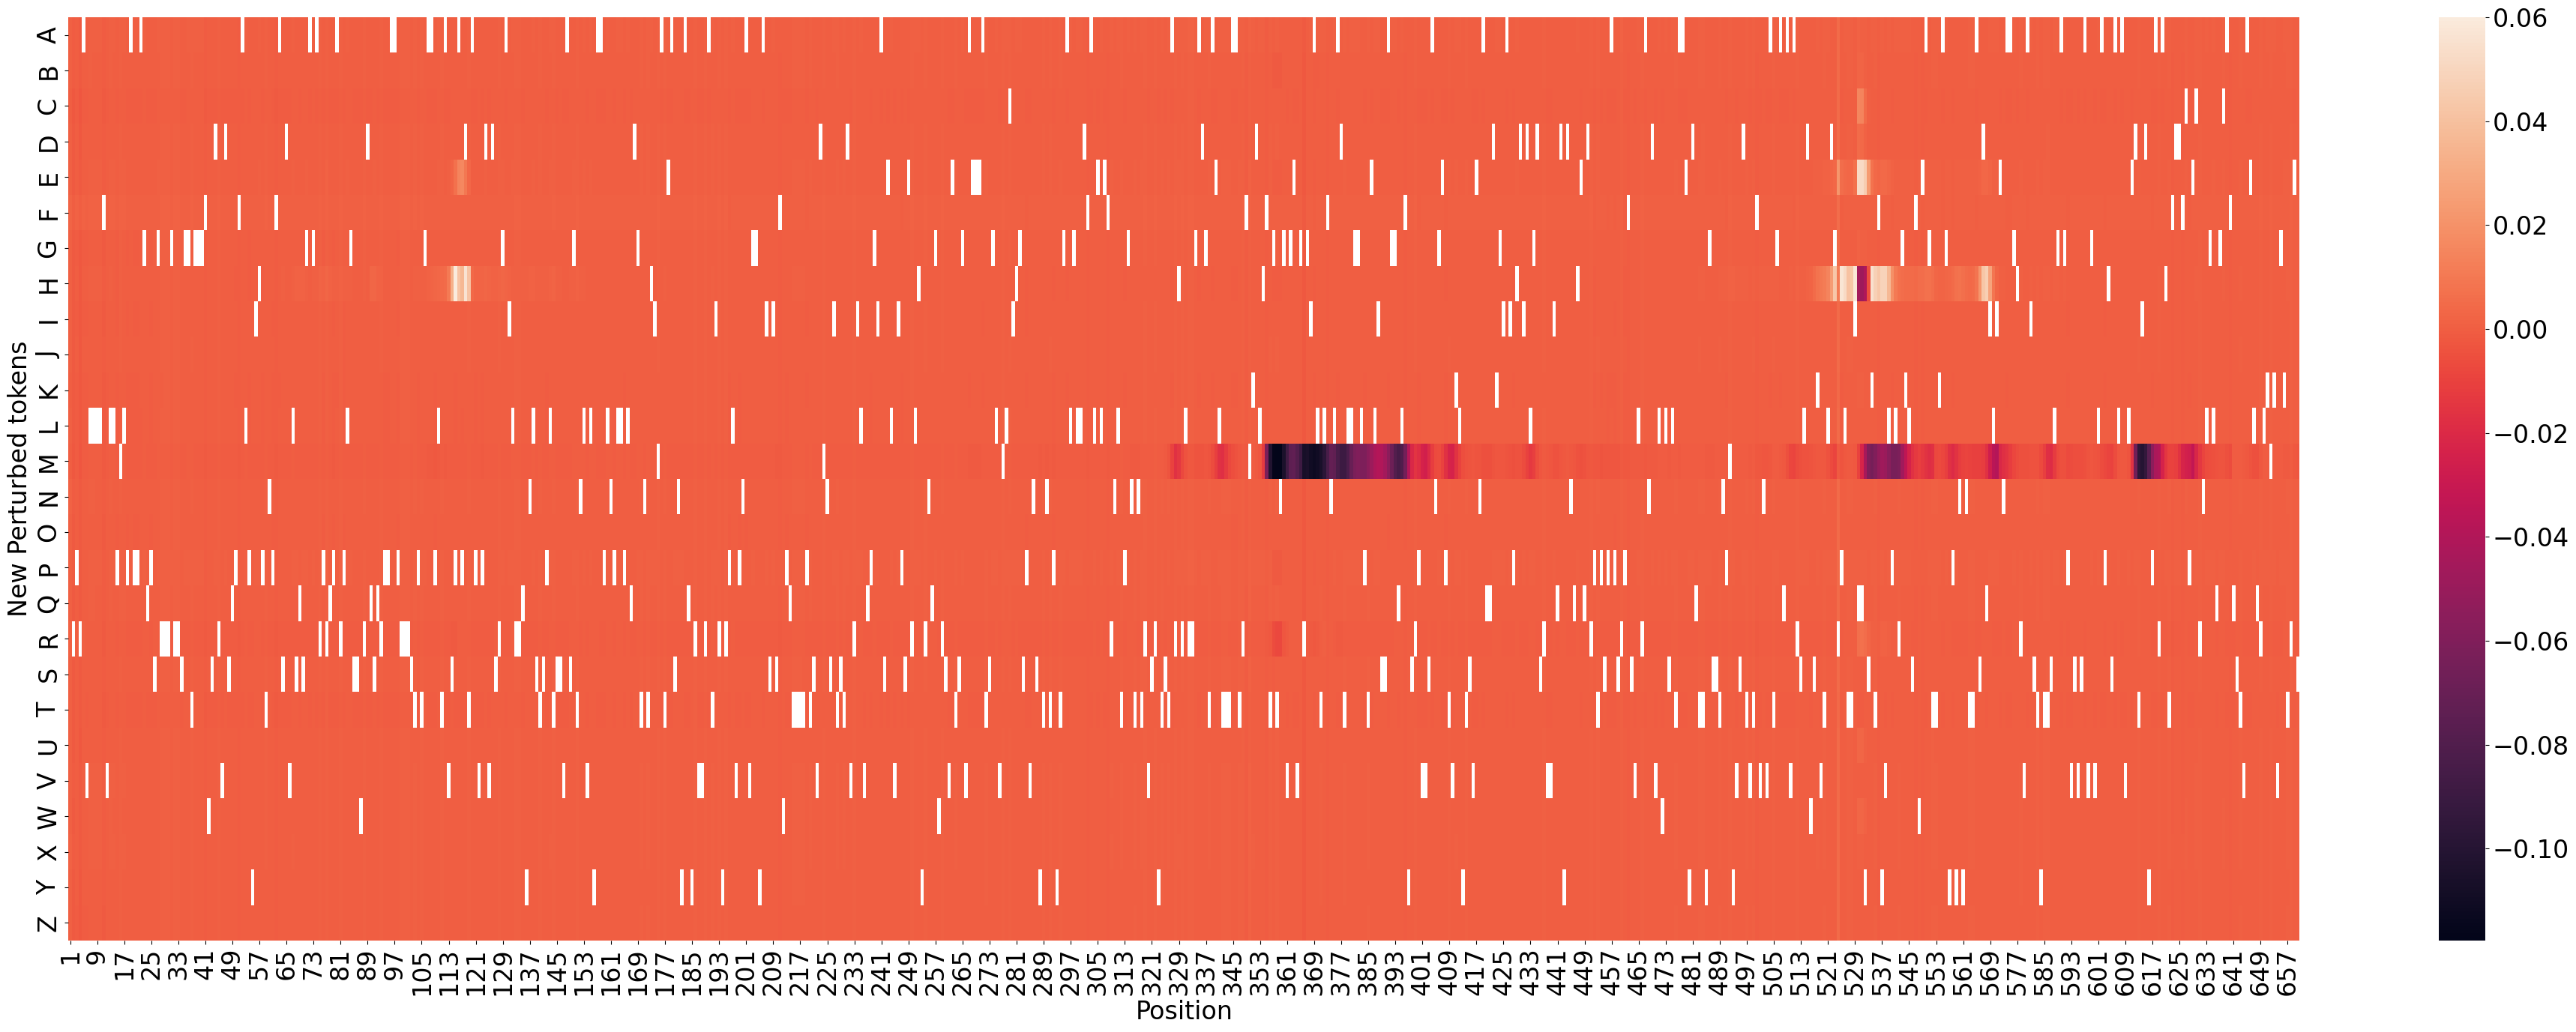

In [16]:
# visualization_utils.pre_plot_config(figsize=(40, 20))
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
ax = sns.heatmap(df)
# plt.rcParams['figure.autolayout'] = True
plt.xlabel('Position', fontsize=24)
plt.ylabel('New Perturbed tokens', fontsize=24)
plt.show()

In [35]:
df.mean(axis=0)

seq_pos
1      0.000704
2     -0.001268
3     -0.000228
4     -0.001727
5     -0.000144
         ...   
656    0.000096
657    0.000283
658    0.000487
659   -0.000272
660   -0.000076
Length: 660, dtype: float64

<Figure size 640x480 with 0 Axes>

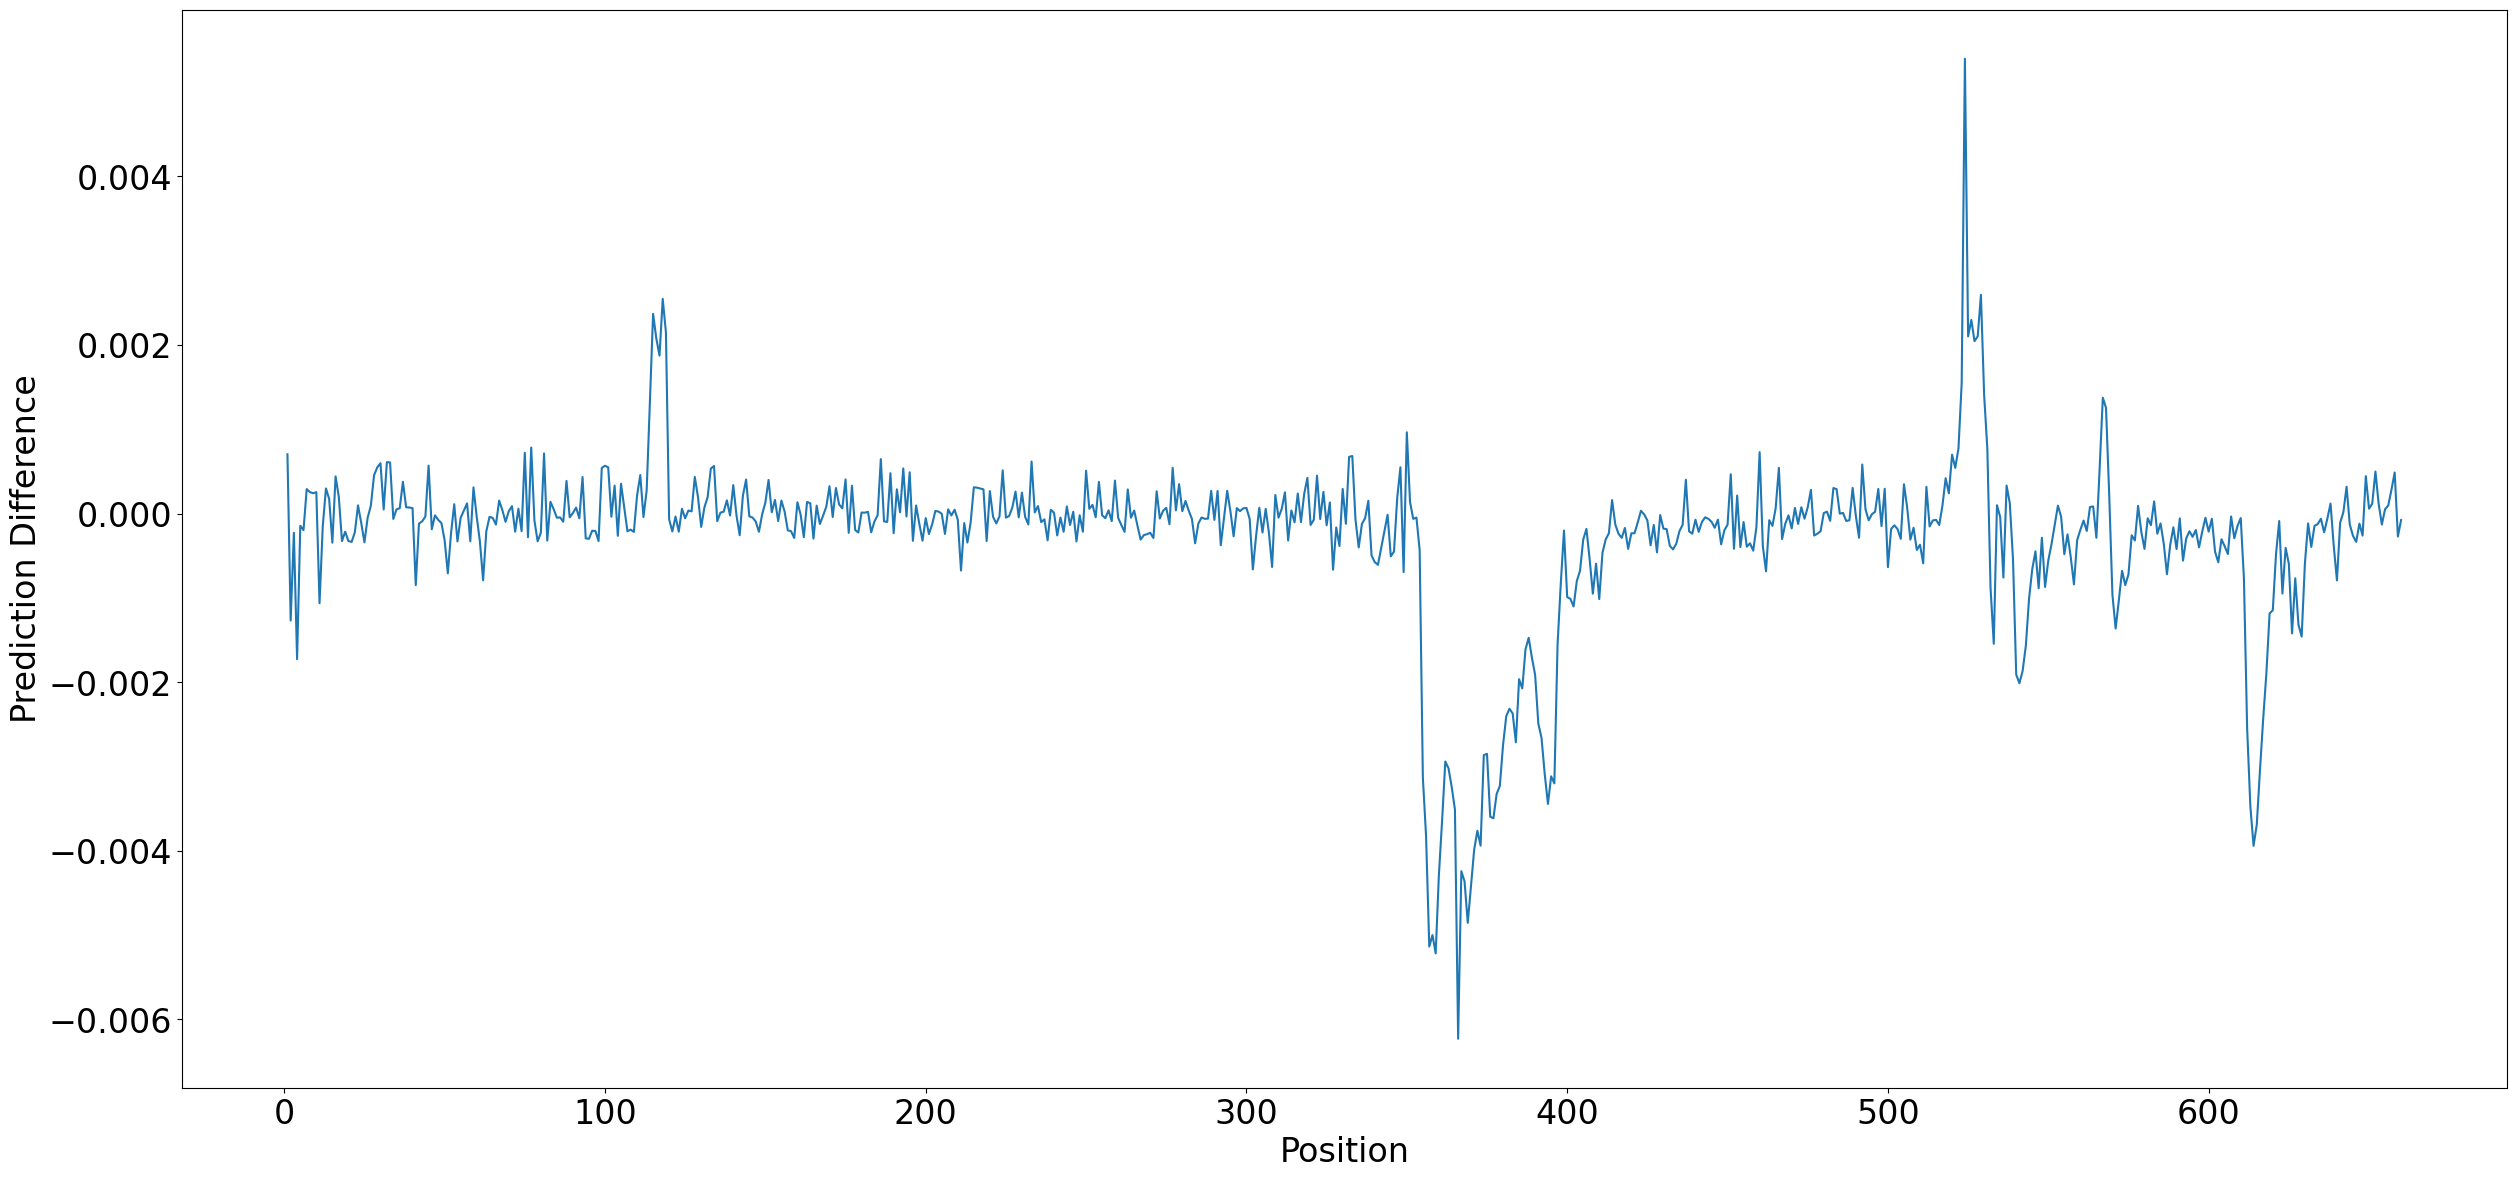

In [36]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.xlabel('Position', fontsize=24)
plt.ylabel('Prediction Difference', fontsize=24)
plt.show()

In [20]:
df.mean(axis=0).idxmin()

139

### Identify important position across all sequences

In [21]:
mean_diff_dfs = [x_df.mean(axis=0) for x_df in diff_dfs]

In [22]:
mean_diff_df = pd.DataFrame(mean_diff_dfs)
mean_diff_df

seq_pos,1,2,3,4,5,6,7,8,9,10,...,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282
0,-0.166174,-0.165589,-0.165637,-0.165190,-0.165157,-0.165039,-0.165025,-0.164962,-0.164850,-0.164712,...,-0.166882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.101279,-0.101289,-0.101577,-0.102003,-0.101475,-0.102128,-0.101559,-0.103648,-0.103158,-0.103338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.147627,-0.148054,-0.148552,-0.147941,-0.148698,-0.148031,-0.147941,-0.148007,-0.148011,-0.147986,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.287268,-0.285404,-0.285506,-0.284184,-0.283761,-0.284068,-0.283944,-0.283768,-0.282201,-0.282513,...,-0.288075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.288138,-0.286268,-0.286370,-0.285052,-0.284632,-0.284949,-0.284829,-0.284655,-0.283084,-0.283399,...,-0.288935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,-0.154273,-0.153882,-0.153988,-0.153854,-0.154061,-0.153977,-0.154059,-0.154049,-0.154390,-0.154123,...,-0.154153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1307,-0.298284,-0.296338,-0.296616,-0.295287,-0.295251,-0.295696,-0.295865,-0.295794,-0.294145,-0.294563,...,-0.299036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1308,-0.110724,-0.110568,-0.110818,-0.110864,-0.111187,-0.110750,-0.111254,-0.110846,-0.110773,-0.110808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1309,-0.149454,-0.149545,-0.149287,-0.149376,-0.149301,-0.149324,-0.149279,-0.149475,-0.149238,-0.148940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


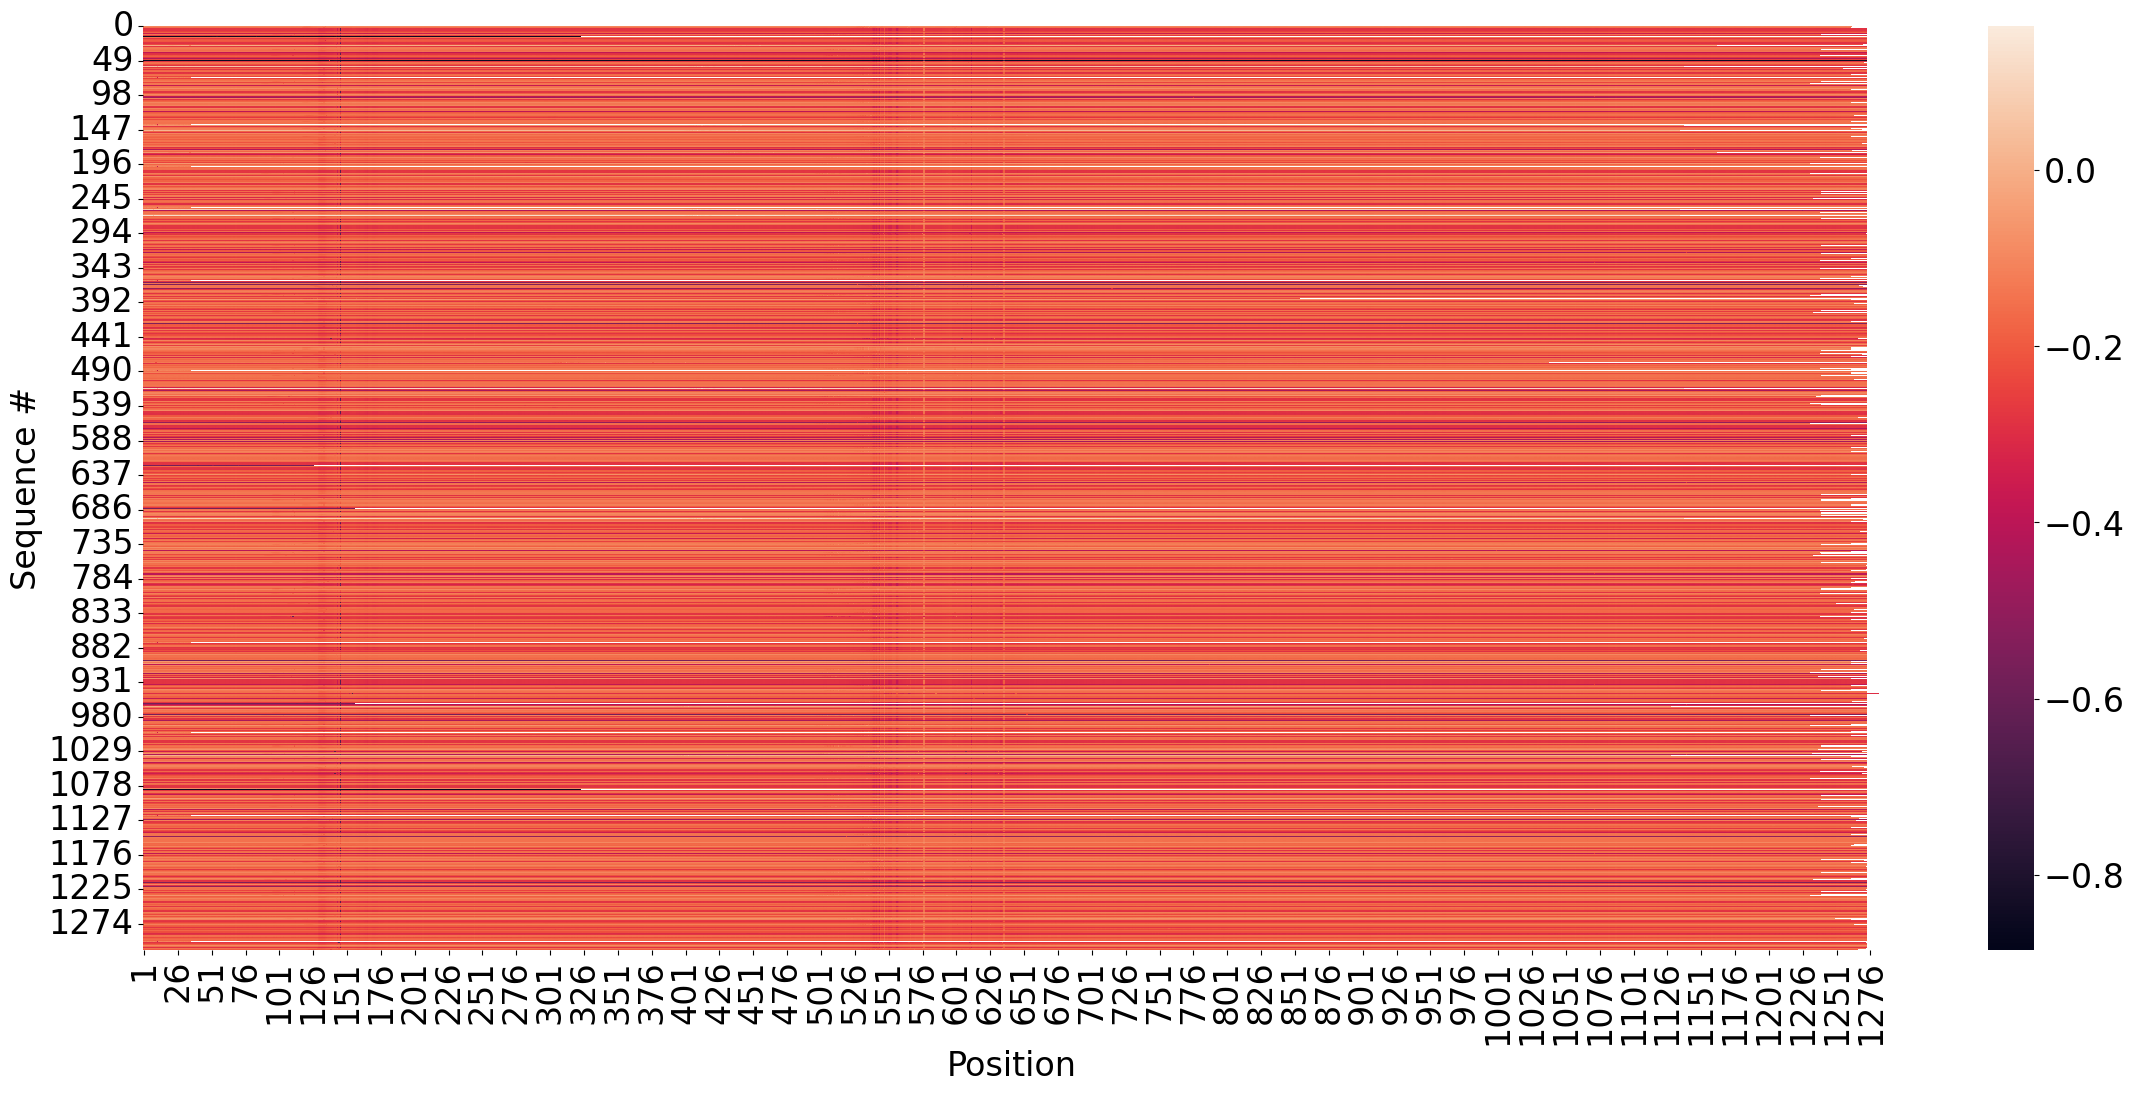

In [23]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df)
plt.xlabel('Position', fontsize=24)
plt.ylabel('Sequence #', fontsize=24)
plt.show()

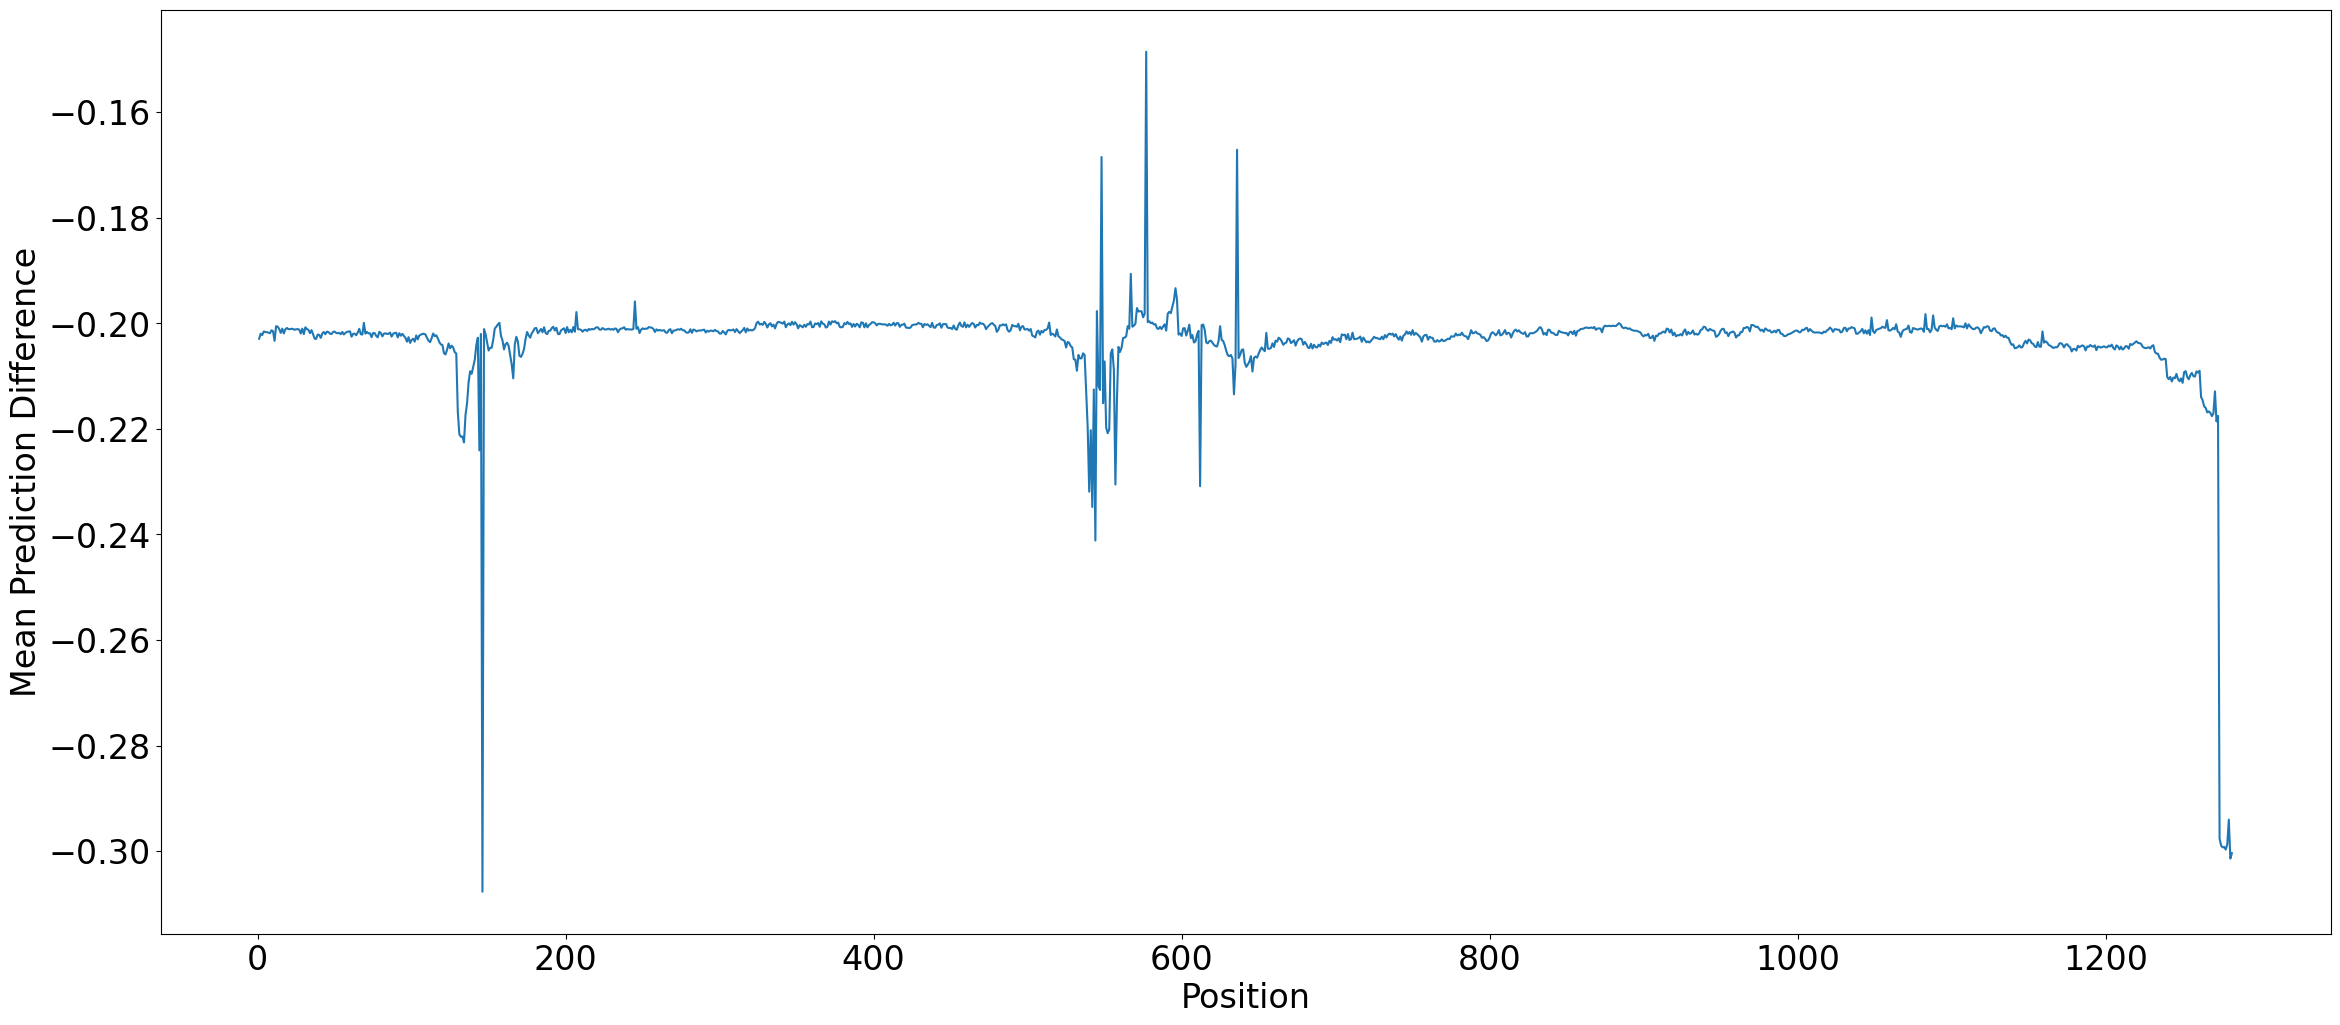

In [24]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.xlabel('Position', fontsize=24)
plt.ylabel('Mean Prediction Difference', fontsize=24)
plt.show()

In [25]:
mean_diff_df.mean(axis=0).idxmin()

146

In [26]:
# retain only negative values i.e. probability of Human host decreases
mean_diff_df[mean_diff_df >= 0 ] = None

# drop all columns (positions) with atleast 10% non-NaN values i.e. this position does not decrease the probability for 90% or more of the sequences
# argument 'thresh': Require that many non-NA values.
mean_diff_df.dropna(axis=1, how="all", thresh=0.9*mean_diff_df.shape[0], inplace=True)

In [27]:
mean_diff_df.shape

(1311, 1249)

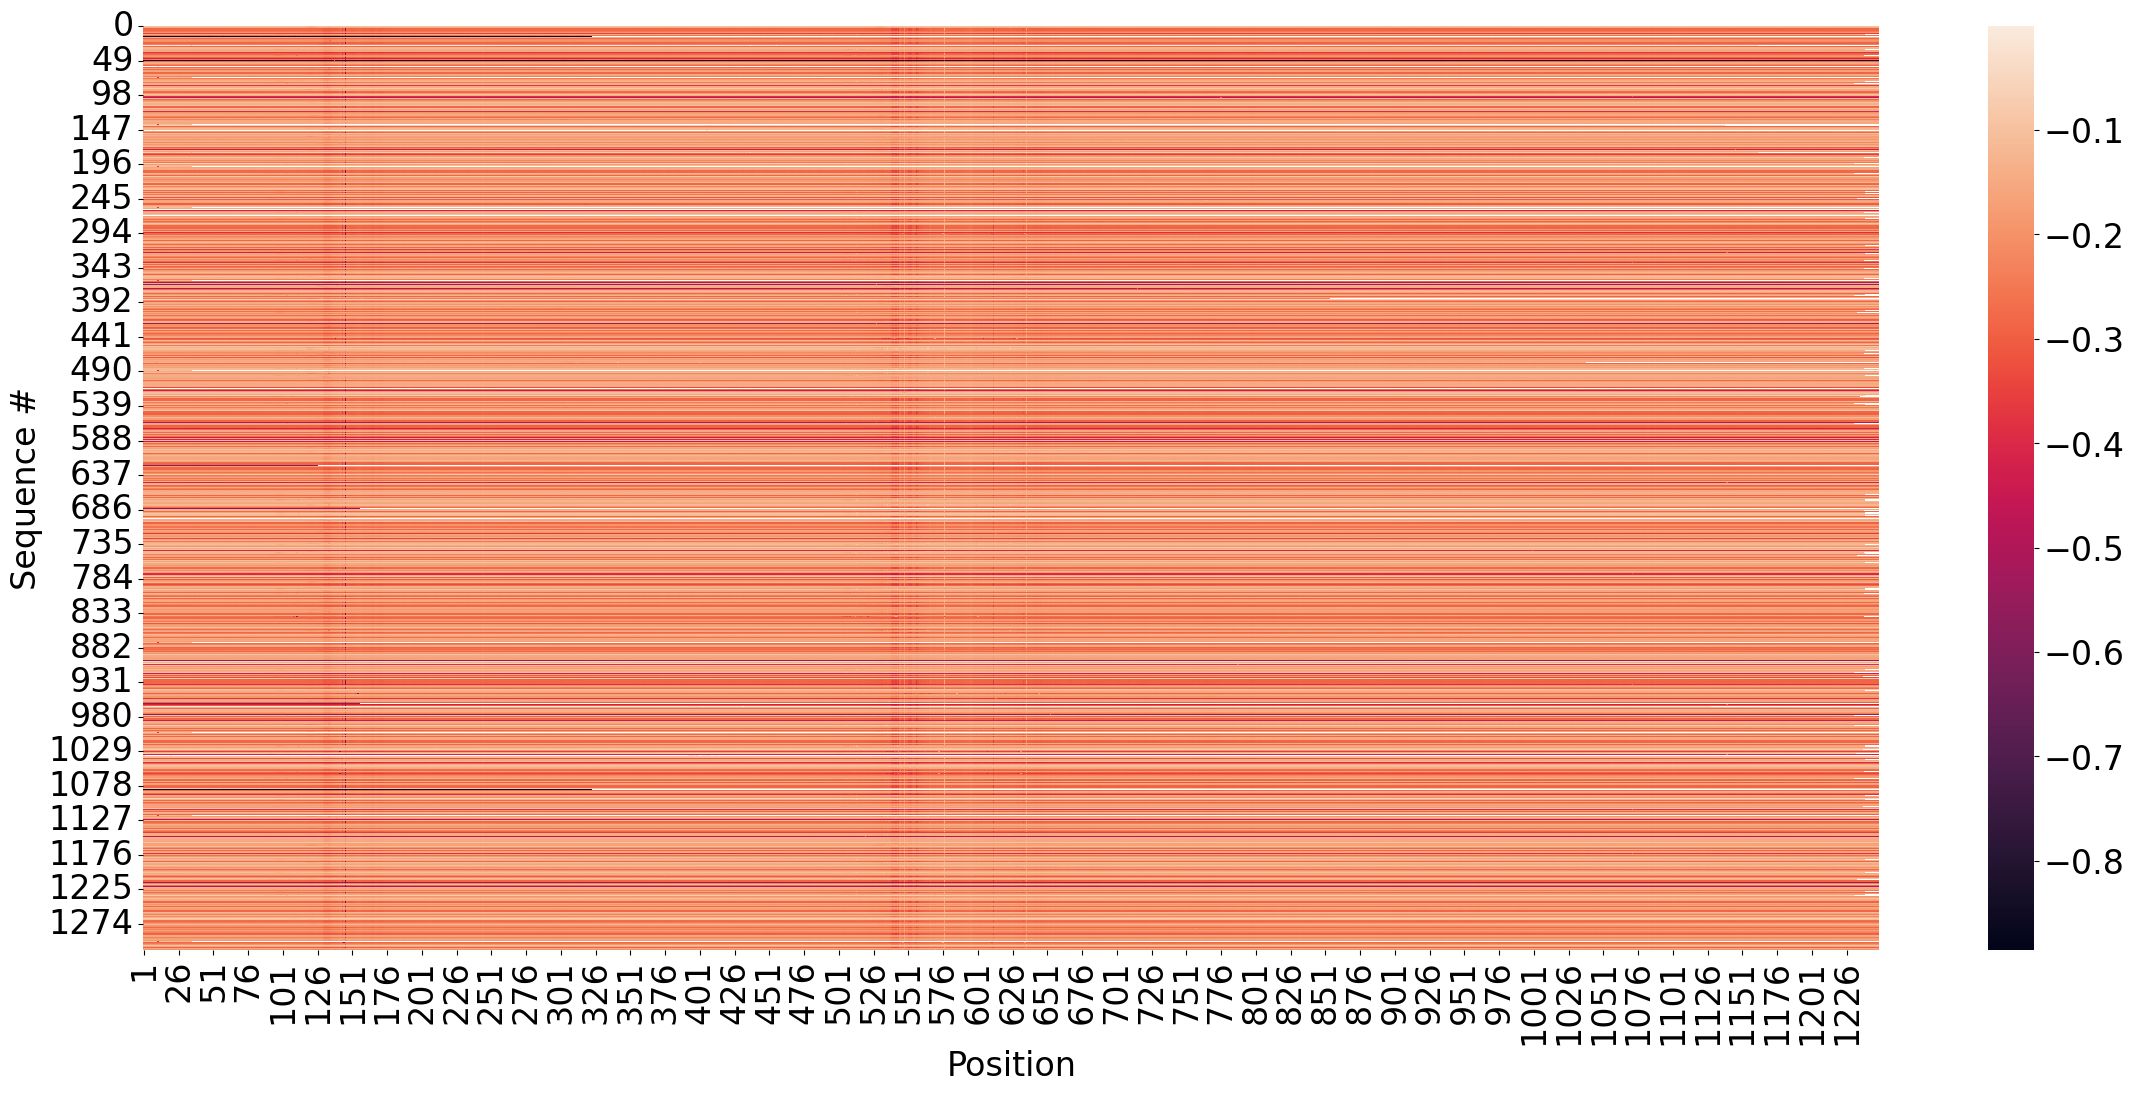

In [28]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df)
plt.xlabel('Position', fontsize=24)
plt.ylabel('Sequence #', fontsize=24)
plt.show()

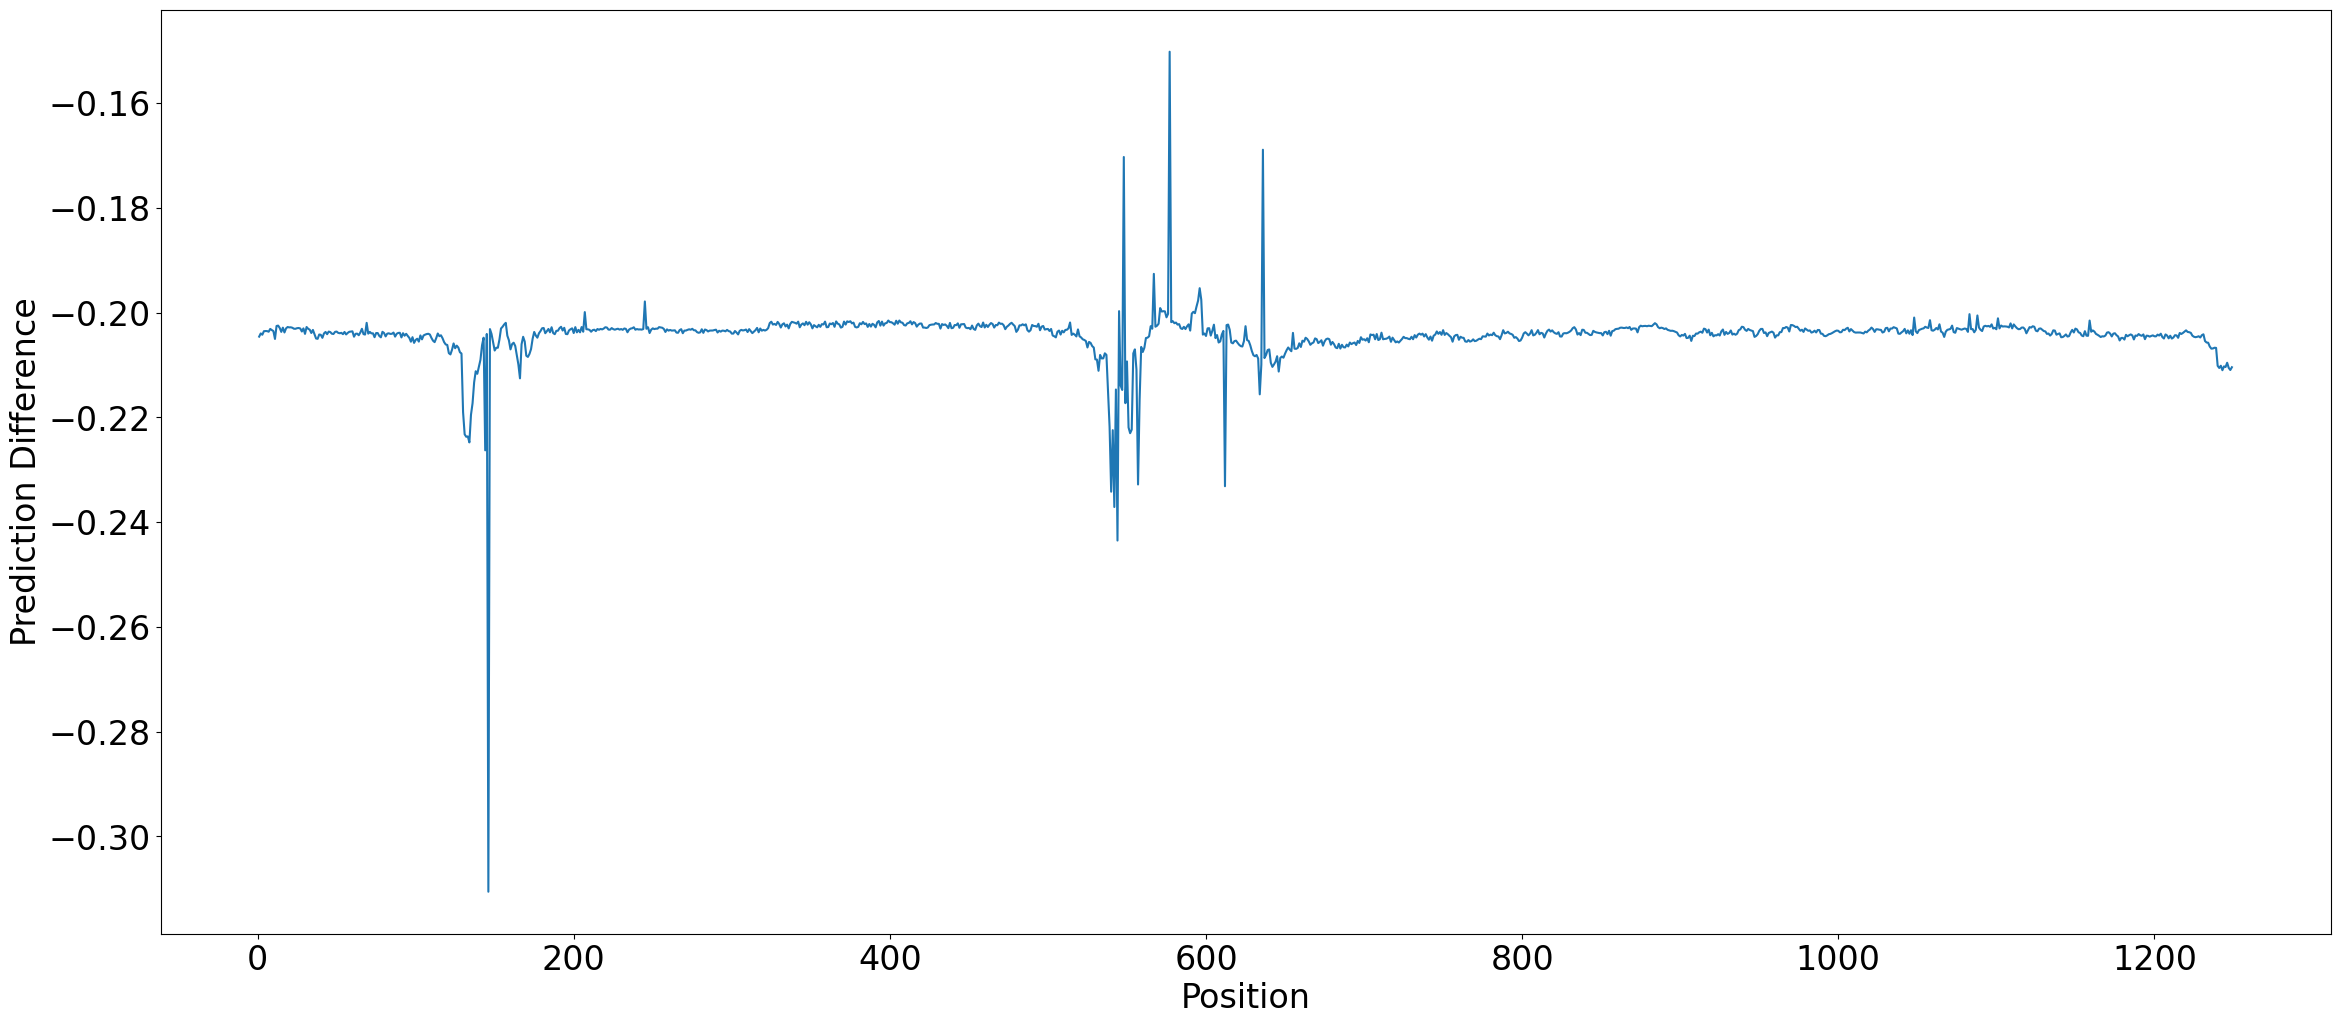

In [29]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.xlabel('Position', fontsize=24)
plt.ylabel('Prediction Difference', fontsize=24)
plt.show()

In [30]:
mean_diff_df.mean(axis=0).nsmallest(10)

seq_pos
146   -0.310583
544   -0.243530
542   -0.237127
540   -0.234203
612   -0.233161
557   -0.232825
144   -0.226307
134   -0.224791
132   -0.223721
133   -0.223649
dtype: float64